In [1]:
#Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mplsoccer import Pitch, VerticalPitch, arrowhead_marker
import ipywidgets as widgets
from highlight_text import  ax_text, fig_text
import matplotlib as mpl

#Read in the data
df = pd.read_csv('Footballdata/Season/SerieA.csv', encoding='latin-1', low_memory = False)

#Adjust to pitch size
df['x'] = df['x']*1.2
df['y'] = df['y']*.8
df['endX'] = df['endX']*1.2
df['endY'] = df['endY']*.8

#remove unwanted records
df = df.loc[~(df['type_displayName'] == 'SubstitutionOff')]
df = df.loc[~(df['type_displayName'] == 'SubstitutionOn')]
df = df.loc[~(df['type_displayName'] == 'FormationChange')]
df = df.loc[~(df['type_displayName'] == 'Challenge')]
df = df.loc[~(df['type_displayName'] == 'FormationSet')]
df = df.loc[~(df['type_displayName'] == 'Start')]
df = df.loc[~(df['type_displayName'] == 'End')]

#remove these unwanted records, they should be ignored as their challenges are failed and the shot continues
#Remove Aerial tag because it would be useless, already have the shot tag after
df = df.loc[~(df['type_displayName'] == 'Error')]
df = df.loc[~(df['type_displayName'] == 'Aerial')]
df = df.loc[~(df['type_displayName'] == 'TakeOn')]
df = df.loc[~(df['type_displayName'] == 'Save')]
df = df.loc[~(df['type_displayName'] == 'BallRecovery')]
df = df.loc[~((df['type_displayName'] == 'Tackle') & (df['outcomeType_displayName'] == 'Unsuccessful'))]

#Find all shots
lis = ['Goal','SavedShot','ShotOnPost','MissedShots']

#Finding next event to remove clearances that come after a shot, because the first passer should receive the credit
df['nextevent'] = df['type_displayName'].shift(-1)

df = df.loc[~((df['type_displayName'] == 'Clearance') & (df['nextevent'].isin(lis)))]

#Variable for SCA (2 passes that directly lead to a shot)
df['SCA']= np.where((df['type_displayName'] == 'Pass') & (df['outcomeType_displayName'] == 'Successful') & 
                    ((df['type_displayName'].shift(-1).isin(lis)) | (df['type_displayName'].shift(-2).isin(lis))) &
                    ((df['teamId'].shift(-1) == df['teamId']) | (df['teamId'].shift(-2) == df['teamId'])),1,0)

#Finding previous event to filter out setpieces
df['prevevent'] = df['type_displayName'].shift(1)

#Remove passes that come after fouls and cards, potential set pieces
df = df.loc[~((df['type_displayName'] == 'Pass') & (df['prevevent'] == 'Foul'))]
df = df.loc[~((df['type_displayName'] == 'Pass') & (df['prevevent'] == 'Card'))]

#Take out corners and throw ins
df = df.loc[(df['x'] < 119.39)]
df = df.loc[(df['y'] > 0)]
df = df.loc[(df['y'] < 80)]

#List of Pass Attempts
PassAttempts = df.loc[(df['type_displayName']=='Pass')]

#Filter for SCA
scadf = df.loc[(df['SCA'] == 1)]

#Checking
#scadf[['id','teamId','playername']]

In [2]:
#List of Successful Take-Ons
SCAList = scadf.groupby(['name','teamId']).size().reset_index().rename(columns={0:'Live Passes SCA'}).sort_values('Live Passes SCA', ascending = False).reset_index()
del SCAList['index']
SCAList.rename(columns = {'teamId':'Team', 'name':'Player'},inplace = True)
SCAList.index += 1
SCAList.head(15)

Player       Team  Live Passes SCA
1               Nicolò Barella      Inter               91
2        Khvicha Kvaratskhelia     Napoli               88
3                Nikola Vlasic     Torino               88
4          Giovanni Di Lorenzo     Napoli               81
5              Roberto Pereyra    Udinese               81
6              Piotr Zielinski     Napoli               80
7             Teun Koopmeiners   Atalanta               76
8                  Rafael Leão      Milan               74
9             Armand Laurienté   Sassuolo               72
10             Felipe Anderson      Lazio               72
11           Gabriel Strefezza      Lecce               70
12            Domenico Berardi   Sassuolo               68
13                Luis Alberto      Lazio               67
14  André-Frank Zambo Anguissa     Napoli               65
15             Emanuele Valeri  Cremonese               65

In [3]:
#Pass Attempts
pass_list = PassAttempts.groupby(['name','teamId']).size().reset_index().rename(columns={0:'Attempted Passes'}).sort_values('name', ascending = True).reset_index()
del pass_list['index']
pass_list.rename(columns = {'teamId':'Team', 'name':'Player'},inplace = True)

#Merge Table
res = pd.merge(pass_list, SCAList, on="Player")
res = res.drop(['Team_y'], axis = 1)
res.rename(columns = {'Team_x':'Team', 'name':'Player'},inplace = True)

#SCA per 100 Live Passes
res['SCA per 100 Live Passes'] =((res['Live Passes SCA'] / res['Attempted Passes'])*100).round(decimals = 1)
res = res.sort_values('SCA per 100 Live Passes', ascending= False).reset_index(drop = True)

#filter when necessary
res = res.loc[(res['Attempted Passes'] > res['Live Passes SCA'])]
#res = res.loc[(res['Attempted Passes'] >= 50)]

#display table
res.index += 1
res

Player           Team  Attempted Passes  Live Passes SCA  \
5        Ronaldo Vieira         Torino                 7                4   
6         Brandon Soppy        Udinese                29               15   
7          Bruno Amione  Hellas Verona                13                6   
8      Eldor Shomurodov           Roma                32               14   
9         Fabio Depaoli      Sampdoria                75               23   
..                  ...            ...               ...              ...   
559          Simon Kjær          Milan               666                1   
560  Sebastiano Luperto         Empoli              1633                4   
561         Omar Colley      Sampdoria               690                1   
562          Juan Musso       Atalanta               673                1   
563        Rui Patrício           Roma               833                1   

     SCA per 100 Live Passes  
5                       57.1  
6                       51.7  
7                       46.2  
8                       43.8  
9                       30.7  
..                       ...  
559                      0.2  
560                      0.2  
561                      0.1  
562                      0.1  
563                      0.1  

[559 rows x 5 columns]

In [4]:
#List it in a combo box
options = scadf["name"].unique()
options = options.tolist()

options = [x for x in options if str(x) != 'nan']
playerlist = widgets.Combobox(
    placeholder='Enter a name',
    options=options,
    description='Player:',
    ensure_option=True,
    disabled=False
)
playerlist

Combobox(value='', description='Player:', ensure_option=True, options=('Ronaldo Vieira', 'Abdelhamid Sabiri', …

In [5]:
#Retrieve player
player = playerlist.value

#make a copy
scadf2 = scadf

#Filter for player
scadf = scadf.loc[scadf['name'] == player]

#Number of SCA
sca = len(scadf.index)

#Retrieve team name from the carries
team = scadf['teamId'].unique()
team = team[0]

#Retrieve Opposition team
oppo = df.loc[(df['teamId']!= team)]
oppo = oppo['teamId'].unique()
oppo = oppo[0]

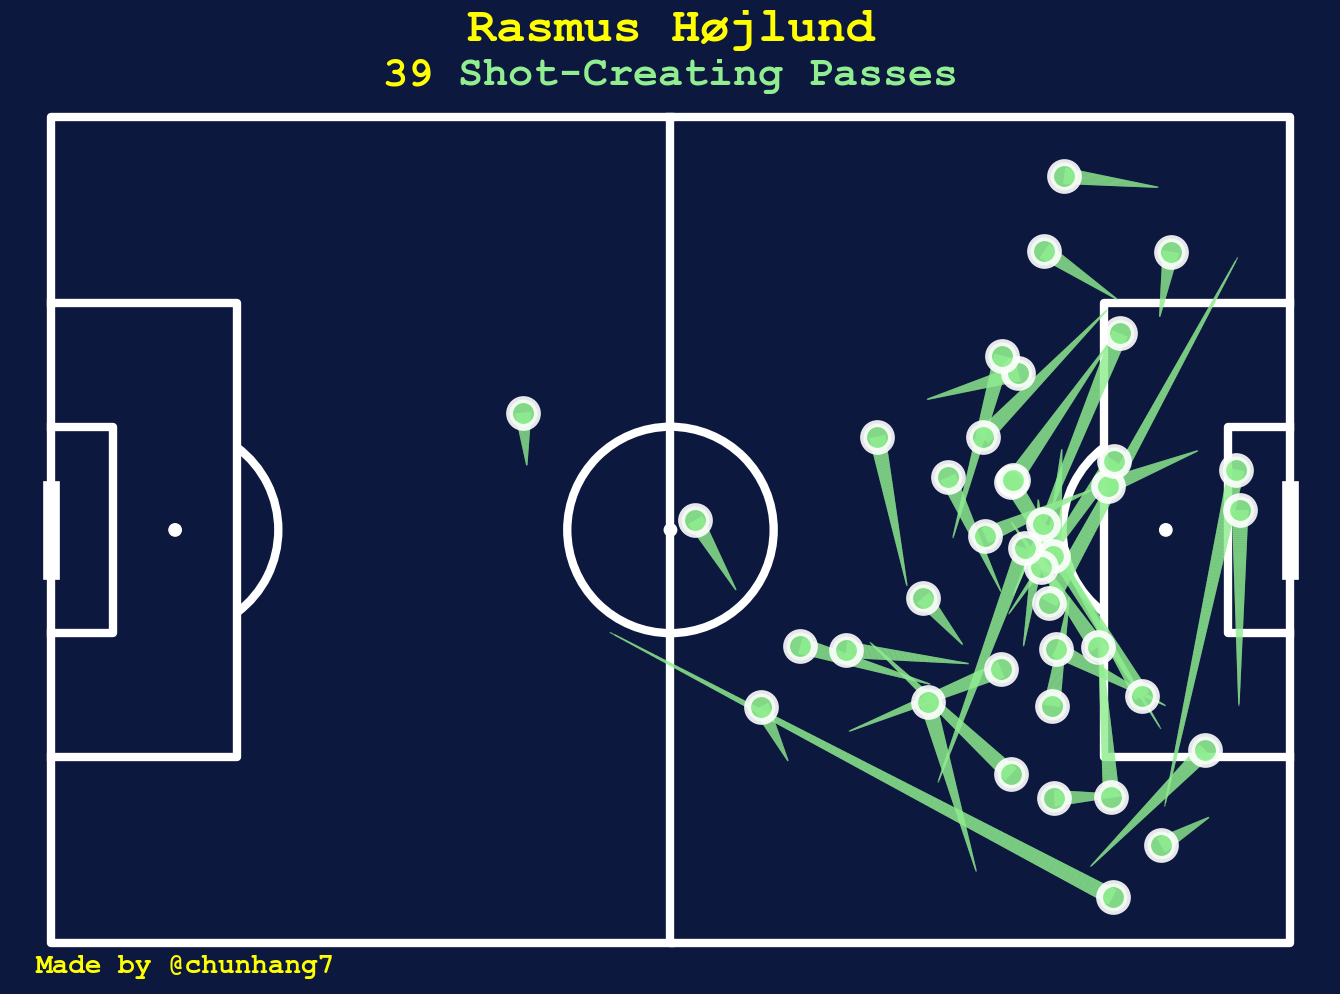

In [6]:
#Make the pitch
pitch = Pitch(pitch_type='statsbomb', pitch_color='#0d183f', line_color='white',linewidth=6, spot_scale=0.005)
fig, ax = pitch.draw(figsize=(14, 11), constrained_layout=False, tight_layout=True)
fig.set_facecolor('#0d183f')

#Inverse y-axis
plt.gca().invert_yaxis()

#plot Passes
pitch.lines(scadf.x, scadf.y, scadf.endX, scadf.endY,
            ax=ax,comet = True, color= 'lightgreen', lw=12, alpha = 0.6)

pitch.scatter(scadf.endX, scadf.endY, edgecolors= 'w', c='lightgreen',
              s = 400, zorder=4, ax=ax, marker = 'o', alpha = 0.9,linewidths=5)

#Title & Annotations
fig.suptitle(player + "\n\n", fontsize=35, color='yellow',
            fontfamily = "Courier New", fontweight = "bold",x=0.5,y=0.9)

highlight_textprops =\
    [{"color": "lightgreen","fontweight": 'bold'}]

Title = fig_text(s = str(sca) + " <Shot-Creating Passes>",
        x = 0.5, y = 0.855, highlight_textprops = highlight_textprops ,color='yellow',
        fontfamily = "Courier New",fontweight='bold', ha='center',fontsize=30);

#Annotations
fig.text(0.26, 0.03,'Made by @chunhang7', fontsize=20, color='yellow', fontweight = 'bold', 
         fontfamily = 'Courier New',ha='right', va='center')

"""fig.text(0.95, 0.03,'vs '+oppo, fontsize=20, color='yellow', fontweight = 'bold', 
         fontfamily = 'Courier New',ha='right', va='center')"""

plt.show()

# Vertical Pitch

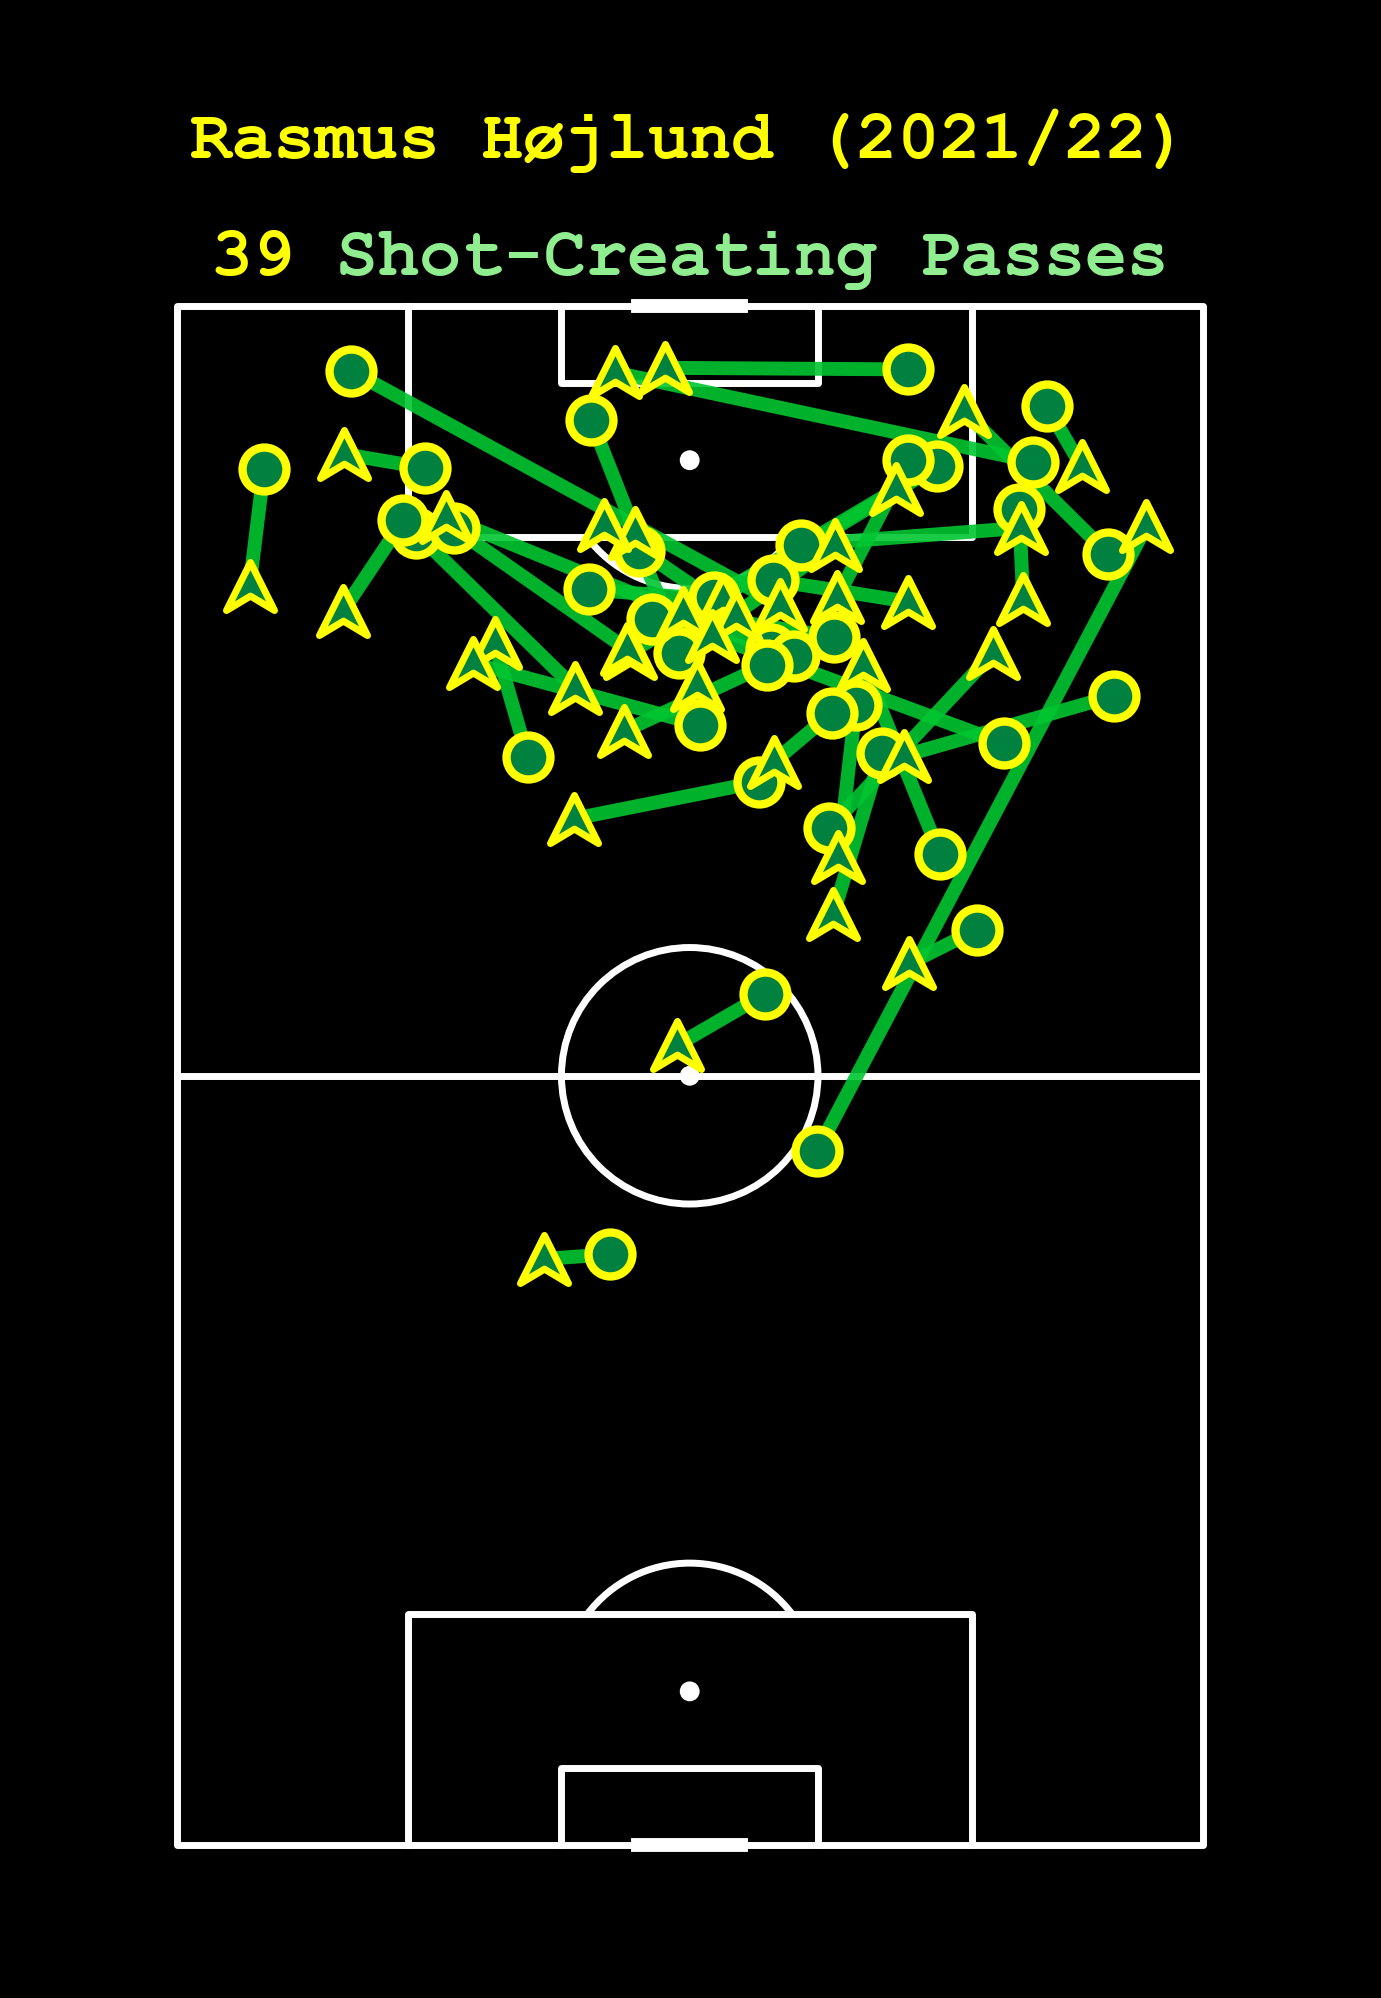

In [7]:
#Set up pitch
pitch = VerticalPitch(pitch_type='statsbomb', 
                  pitch_color='#000000', line_color='white',half = False,
                  line_zorder=1, linewidth=5, spot_scale=0.006)

fig,ax = pitch.draw(figsize=(30, 20), constrained_layout=False, tight_layout=True)
fig.set_facecolor('#000000')

#Inverse the y-axis
plt.gca().invert_xaxis()

"""#plot Passes
pitch.lines(scadf.x, scadf.y, scadf.endX, scadf.endY,
            ax=ax,comet = True, color= 'lightgreen', lw=16, alpha = 0.6)

pitch.scatter(scadf.endX, scadf.endY, edgecolors= 'w', c='#008140',
              s = 500, zorder=4, ax=ax, marker = 'o', alpha = 0.9,linewidths=4)

"""
pitch.scatter(scadf.x, scadf.y, edgecolors= 'yellow', c='#008140',
              s = 1000, zorder=4, ax=ax, marker = 'o', linewidth=6)

pitch.lines(scadf.x, scadf.y, scadf.endX, scadf.endY,
            ax=ax, color= '#00c631', lw=10, alpha = 0.9)

pitch.scatter(scadf.endX, scadf.endY, edgecolors= 'yellow', c='#008140',marker=arrowhead_marker,
              s = 1200, zorder=4, ax=ax, linewidth=5)


#Title
plt.text(40,121,player+" (2021/22)\n\n",color='yellow', ha='center',
          size=50, fontfamily = "Courier New", fontweight = "bold")

highlight_textprops =\
    [{"color": "lightgreen","fontweight": 'bold'}]

Title = fig_text(s = str(sca) + " <Shot-Creating Passes>",
        x = 0.5, y = 0.885, highlight_textprops = highlight_textprops ,color='yellow',
        fontfamily = "Courier New",fontweight='bold', ha='center',fontsize=50);
"""
Title = fig_text(s = "103 <Shot-Creating Passes>",
        x = 0.5, y = 0.885, highlight_textprops = highlight_textprops ,color='yellow',
        fontfamily = "Courier New",fontweight='bold', ha='center',fontsize=50);
"""
#Space
ax.text(45, 142, 'Space', va='center', ha='left', fontsize=25, color='black',fontweight='bold',fontfamily='Courier New')
ax.text(-5, -10, 'Space', va='center', ha='left', fontsize=25, color='black',fontweight='bold',fontfamily='Courier New')
ax.text(93, -10, 'Space', va='center', ha='left', fontsize=25, color='black',fontweight='bold',fontfamily='Courier New')

plt.show()

# Attacking Half Pitch

In [8]:
#Set up pitch
mpl.rcParams['figure.dpi'] = 500
pitch = VerticalPitch(pitch_type='statsbomb', 
                  pitch_color='#000000', line_color='white',half = True,
                  line_zorder=-3, linewidth=8, spot_scale=0.003)

fig,ax = pitch.draw(figsize=(30, 20), constrained_layout=False, tight_layout=True)
fig.set_facecolor('#000000')

#Inverse the y-axis
plt.gca().invert_xaxis()

"""#plot Passes
pitch.lines(scadf.x, scadf.y, scadf.endX, scadf.endY,
            ax=ax,comet = True, color= 'lightgreen', lw=30, alpha = 0.6)

pitch.scatter(scadf.endX, scadf.endY, edgecolors= 'w', c='#008140',
              s = 1500, zorder=4, ax=ax, marker = 'o', alpha = 0.9,linewidths=7)

"""
pitch.scatter(scadf.x, scadf.y, edgecolors= 'yellow', c='#008140',
              s = 1000, zorder=4, ax=ax, marker = 'o', linewidth=6)

pitch.lines(scadf.x, scadf.y, scadf.endX, scadf.endY,
            ax=ax, color= '#00c631', lw=10, alpha = 0.9)

pitch.scatter(scadf.endX, scadf.endY, edgecolors= 'yellow', c='#008140',marker=arrowhead_marker,
              s = 1200, zorder=4, ax=ax, linewidth=5)


#Title & Annotations
fig.suptitle("\n\n" + player + "\n", fontsize=80, color='yellow',
            fontfamily = "Courier New", fontweight = "bold",y=0.98)

highlight_textprops =\
    [{"color": "#00c631","fontweight": 'bold'}]

Title = fig_text(s = "89" + " <Shot-Creating Passes>" + " | Bundesliga",
        x = 0.5, y = 0.8, highlight_textprops = highlight_textprops ,color='yellow',
        fontfamily = "Courier New",fontweight='bold', ha='center',fontsize=60);

plt.show()

In [14]:
#Team
#Combo box, choose team
options = scadf2["teamId"].unique()
options = options.tolist()

options = [x for x in options if str(x) != 'nan']
teamlist = widgets.Combobox(
    placeholder='Enter a team',
    options=options,
    description='Team:',
    ensure_option=True,
    disabled=False
)
teamlist

Combobox(value='', description='Team:', ensure_option=True, options=('Liverpool', '13', '19', '174', '29', '30…

In [17]:
#Retrieve Team
team = teamlist.value

#Retrieve Opposition team (only use when there's two available teams for selection)
oppo = scadf2.loc[(scadf2['teamId']!= team)]
oppo = oppo['teamId'].unique()
oppo = oppo[0]

#Filter for team
scadf2 = scadf2[scadf2['teamId']== team]

In [18]:
#Create new varaible to find out if the touch or pass occured in the final 3rd
scadf2['right']=np.where(scadf2['y'].between(0,26.6),1,0)

scadf2['center']=np.where(scadf2['y'].between(26.7,53.3),1,0)

scadf2['left']=np.where(scadf2['y'].between(53.4,80),1,0)

#Sum of touches from all 3 sides, and identify the percentage
Right = scadf2['right'].sum()
Center = scadf2['center'].sum()
Left = scadf2['left'].sum()

#Turn them into strings
Right=str(Right)
Center=str(Center)
Left=str(Left)

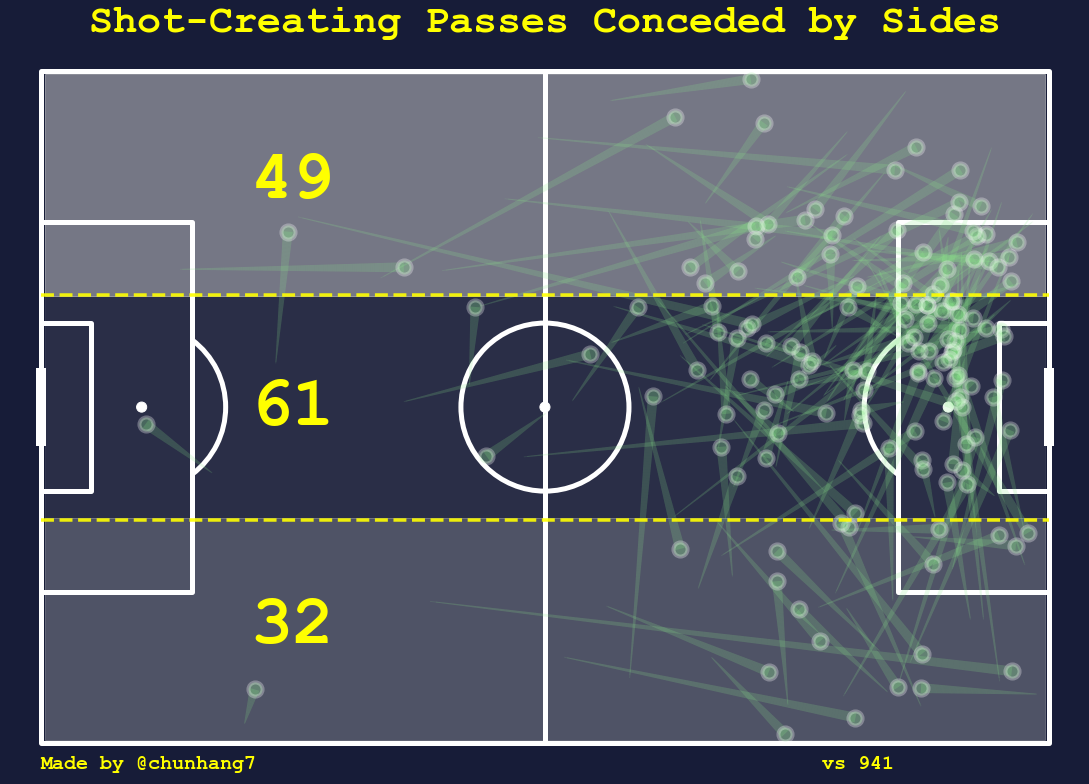

In [19]:
#Make the pitch
pitch = Pitch(pitch_type='statsbomb', pitch_color='#171c38', line_color='white',linewidth=5, spot_scale=0.005)
fig, ax = pitch.draw(figsize=(16, 11), constrained_layout=False, tight_layout=True)
fig.set_facecolor('#171c38')
mpl.rcParams['figure.dpi'] = 300

#inverse y-axis
plt.gca().invert_yaxis()

#plot Passes
pitch.lines(scadf2.x, scadf2.y, scadf2.endX, scadf2.endY,
            ax=ax,comet = True, color= 'lightgreen', lw=10, alpha = 0.1)

pitch.scatter(scadf2.endX, scadf2.endY, edgecolors= 'w', c='lightgreen',
              s = 200, zorder=4, ax=ax, marker = 'o', alpha = 0.3,linewidths=4)


#Draw line
ax.plot([0,120], [26.6, 26.6], c='yellow', lw=3.5, ls='--', zorder=19, alpha=0.9)

ax.plot([0,120], [53.3, 53.3], c='yellow', lw=3.5, ls='--', zorder=19, alpha=0.9)


#set title
"""plt.title(team + "'s Goal-Creating Actions via Passes by Thirds",color='yellow',size=35, 
          fontfamily = "Courier New", fontweight = "bold")"""

plt.title("Shot-Creating Passes Conceded by Sides",color='yellow',size=40, 
          fontfamily = "Courier New", fontweight = "bold")

ax.text(25,65, Left, fontsize=70, 
       color='yellow',fontweight = "bold",fontfamily = "Courier New")

ax.text(25,38, Center, fontsize=70, 
       color='yellow',fontweight = "bold",fontfamily = "Courier New")

ax.text(25,12, Right, fontsize=70, 
       color='yellow',fontweight = "bold",fontfamily = "Courier New")

ax.text(-0.1, -2.5, 'Made by @chunhang7', va='center', ha='left', fontsize=20, color='yellow',
        fontweight = "bold",fontfamily = "Courier New")

ax.text(93, -2.5, 'vs '+ oppo, va='center', ha='left', fontsize=20, color='yellow',
        fontweight = "bold",fontfamily = "Courier New")

#shade
plt.axvspan(0.5,119.5,ymin=0.05,ymax=0.35,color='lightgrey',zorder=-1,alpha=0.3)

plt.axvspan(0.5,119.5,ymin=0.35,ymax=0.65,color='lightgrey',zorder=-1,alpha=0.1)

plt.axvspan(0.5,119.5,ymin=0.65,ymax=0.95,color='lightgrey',zorder=-1,alpha=0.5)

plt.show()

# Vertical Full Pitch

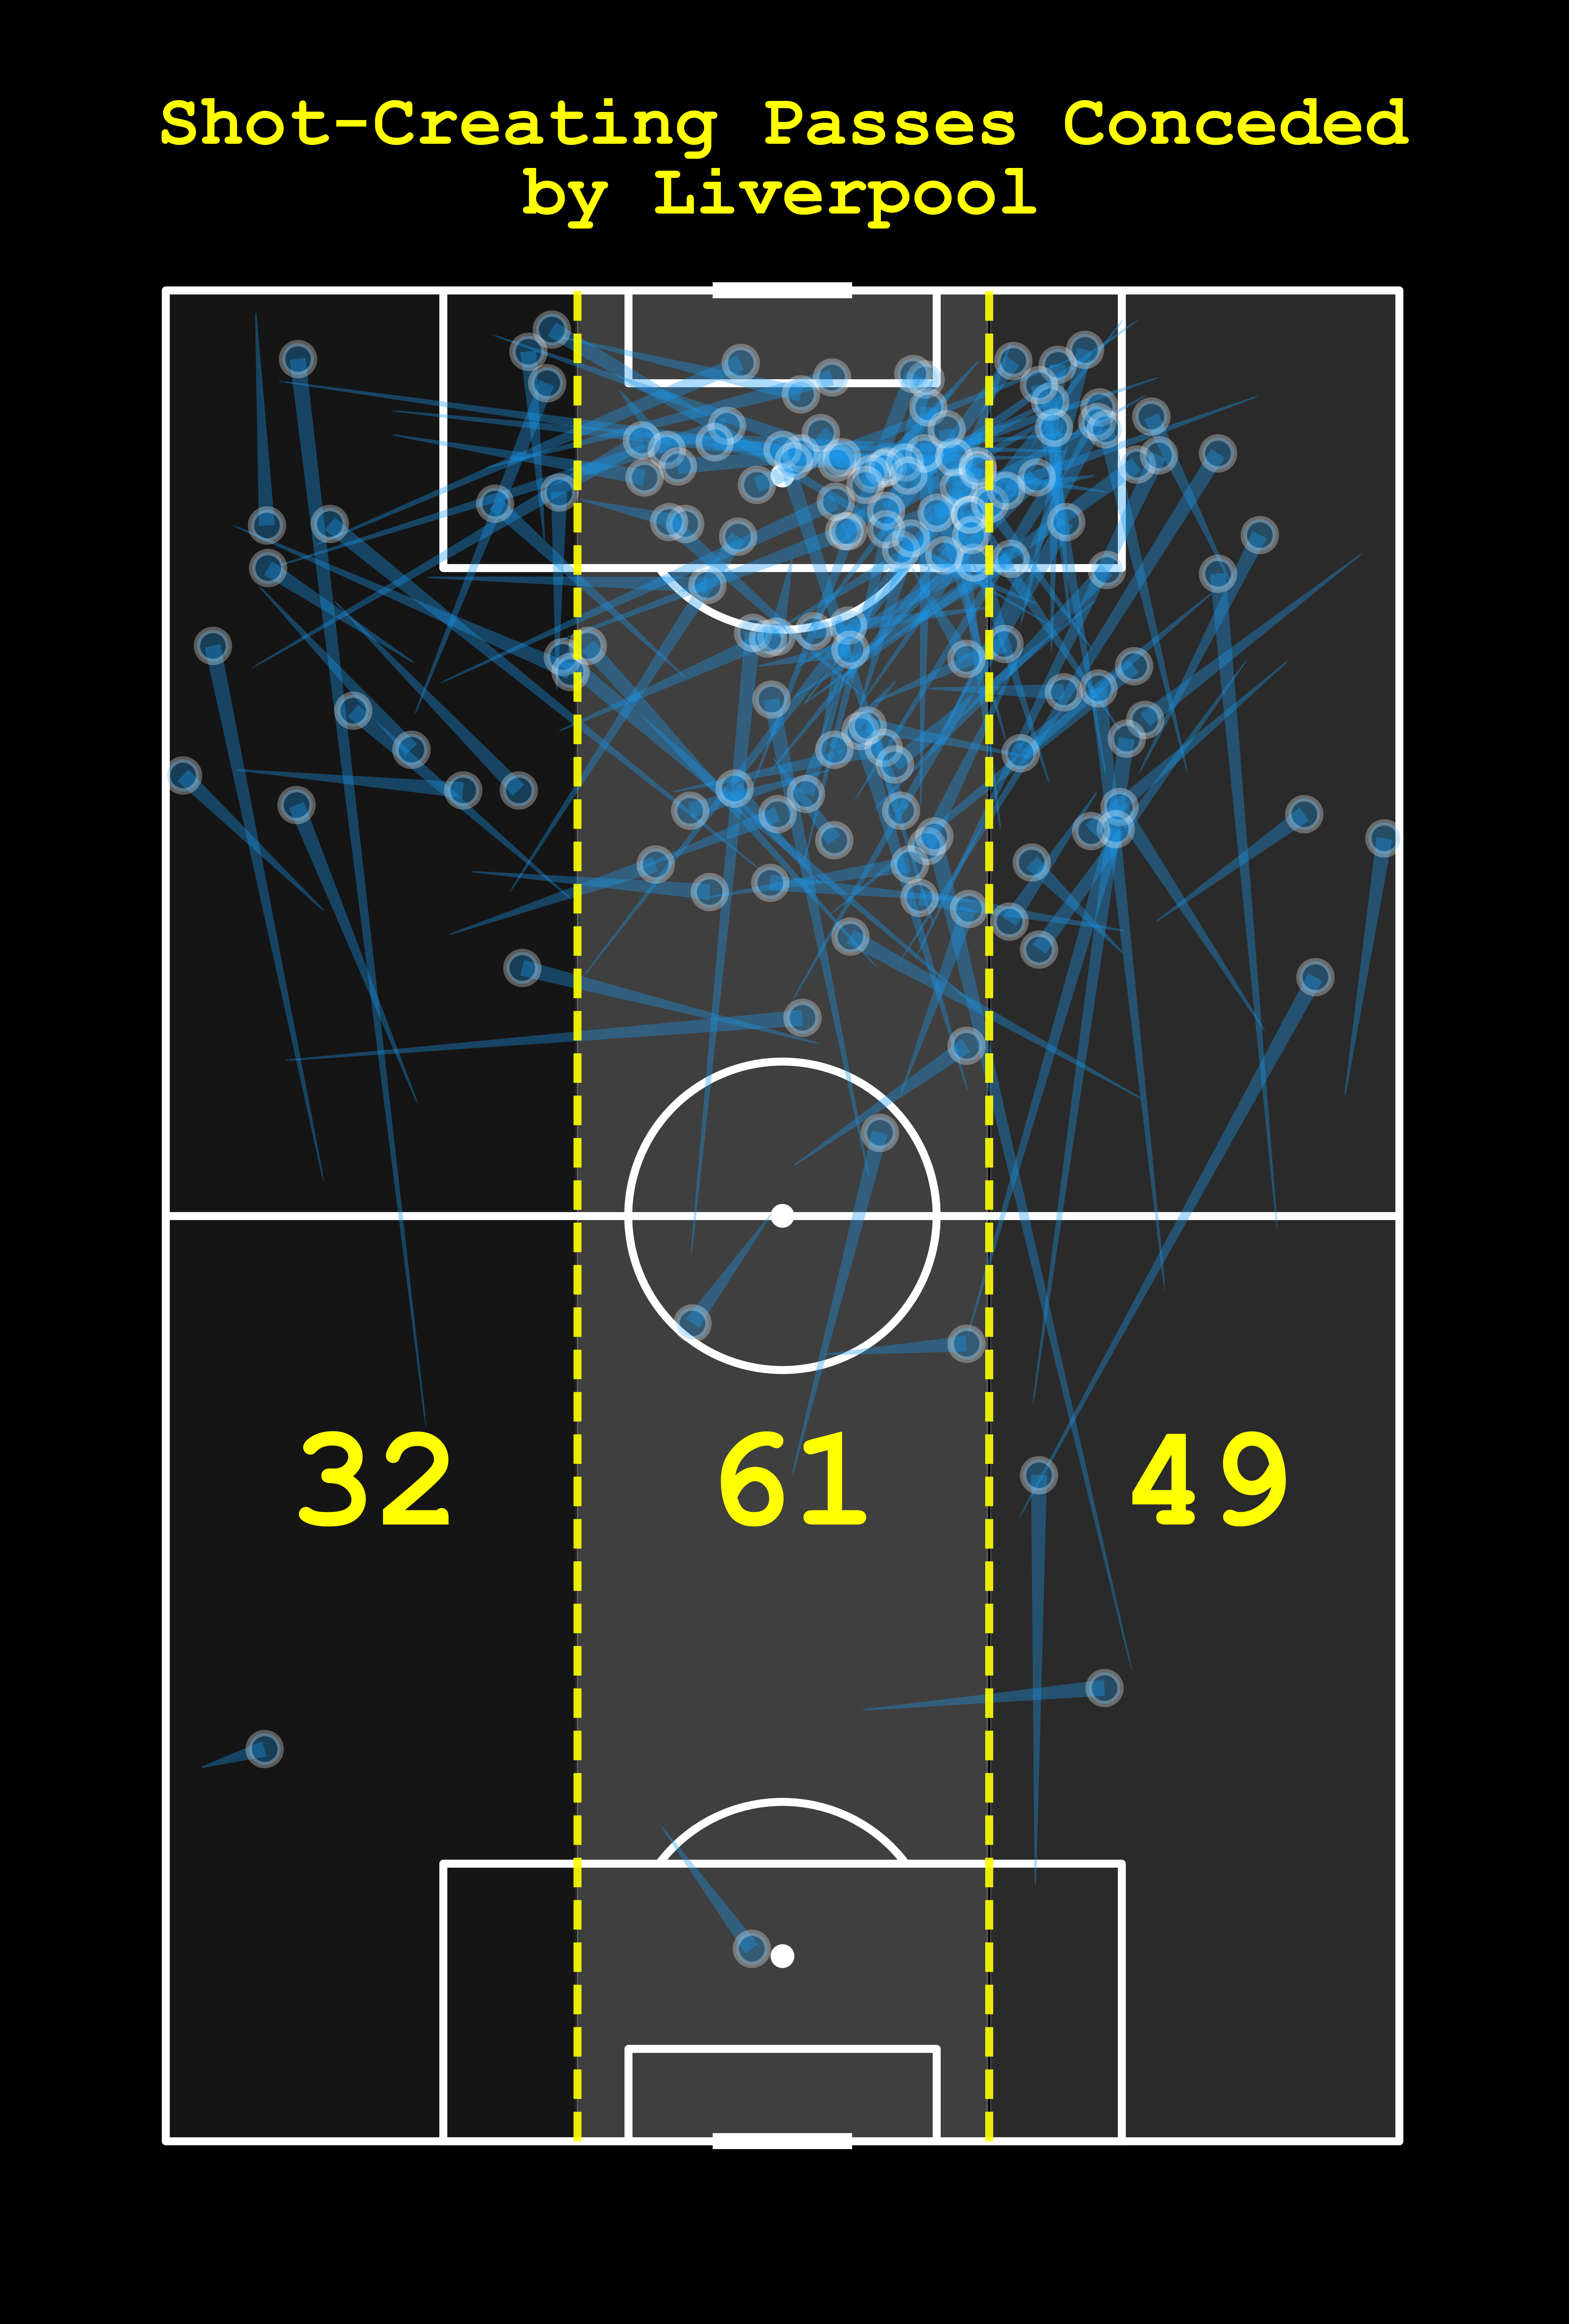

In [20]:
#Set up pitch
pitch = VerticalPitch(pitch_type='statsbomb', 
                  pitch_color='#000000', line_color='white',half = False,
                  line_zorder=1, linewidth=5, spot_scale=0.006)

fig,ax = pitch.draw(figsize=(30, 20), constrained_layout=False, tight_layout=True)
fig.set_facecolor('#000000')

#Inverse the y-axis
#plt.gca().invert_xaxis()

#plot Passes
pitch.lines(scadf2.x, scadf2.y, scadf2.endX, scadf2.endY,
            ax=ax,comet = True, color= '#1d9bf0', lw=10, alpha = 0.2)

pitch.scatter(scadf2.endX, scadf2.endY, edgecolors= 'w', c='#1d9bf0',
              s = 400, zorder=4, ax=ax, marker = 'o', alpha = 0.3,linewidths=4)

#Draw line
ax.plot([53.4,53.4], [0,120], c='yellow', lw=5, ls='--', zorder=19, alpha=0.9)

ax.plot([26.7, 26.7], [0,120], c='yellow', lw=5, ls='--', zorder=19, alpha=0.9)

#Title
plt.text(40,125,"Shot-Creating Passes Conceded\nby Liverpool",color='yellow', ha='center',
          size=45, fontfamily = "Courier New", fontweight = "bold")

#Space
ax.text(55,137, 'Space', va='center', ha='left', fontsize=25, color='black',fontweight='bold',fontfamily='Courier New')
ax.text(-10, -10, 'Space', va='center', ha='left', fontsize=25, color='black',fontweight='bold',fontfamily='Courier New')
ax.text(82.5, -10, 'Space', va='center', ha='left', fontsize=25, color='black',fontweight='bold',fontfamily='Courier New')

#Text
ax.text(62,40, Left, fontsize=90, 
       color='yellow',fontweight = "bold",fontfamily = "Courier New")

ax.text(35,40, Center, fontsize=90, 
       color='yellow',fontweight = "bold",fontfamily = "Courier New")

ax.text(8,40, Right, fontsize=90, 
       color='yellow',fontweight = "bold",fontfamily = "Courier New")

#shade
plt.axvspan(0,26.6, ymin=0.03, ymax=0.97, color='lightgrey',zorder=-1,alpha=0.1)
plt.axvspan(26.7,53.3, ymin=0.03, ymax=0.97, color='lightgrey',zorder=-1,alpha=0.3)
plt.axvspan(53.5,80, ymin=0.03, ymax=0.97, color='lightgrey',zorder=-1,alpha=0.2)

plt.show()